In [1]:
# library import
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [2]:
# remove features which are text, id, and labels 
def filter_csv_header(csv_file_path, strings_to_remove):
    with open(csv_file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        header = next(reader)
        filtered_header = [column for column in header if column not in strings_to_remove]
    return filtered_header

text_features = ["title", "overview", "tagline", "production_companies"]
label_features = ["id", "rate_category", "average_rate"]

features_without_text = filter_csv_header("/Users/felikskong/Desktop/IML/A2/A2-Data_files/TMDB_evaluate.csv", text_features + label_features)
print(features_without_text)

# read the three data sets
train = pd.read_csv("A2-Data_files/TMDB_train.csv")
evaluate = pd.read_csv("A2-Data_files/TMDB_evaluate.csv")
test = pd.read_csv("A2-Data_files/TMDB_test.csv")

# since some languages may not exist across three data sets, concatenate all the original_language columns
from sklearn.preprocessing import LabelEncoder
all_languages = pd.concat([train["original_language"], evaluate["original_language"], test["original_language"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_languages)
train['original_language'] = label_encoder.transform(train['original_language'])
evaluate['original_language'] = label_encoder.transform(evaluate['original_language'])
test['original_language'] = label_encoder.transform(test['original_language'])

# data preparation

# 37 features eliminating text features
X_train_without_text = train[features_without_text]
X_evaluate_without_text = evaluate[features_without_text]
# use rate-category us label
y_train_category = train['rate_category']
y_evaluate_category = evaluate['rate_category']

['release_year', 'runtime', 'budget', 'revenue', 'adult', 'original_language', 'popularity', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'product_of_Canada', 'product_of_France', 'product_of_Germany', 'product_of_India', 'product_of_Italy', 'product_of_Japan', 'product_of_Spain', 'product_of_UK', 'product_of_USA', 'product_of_other_countries', 'vote_count']


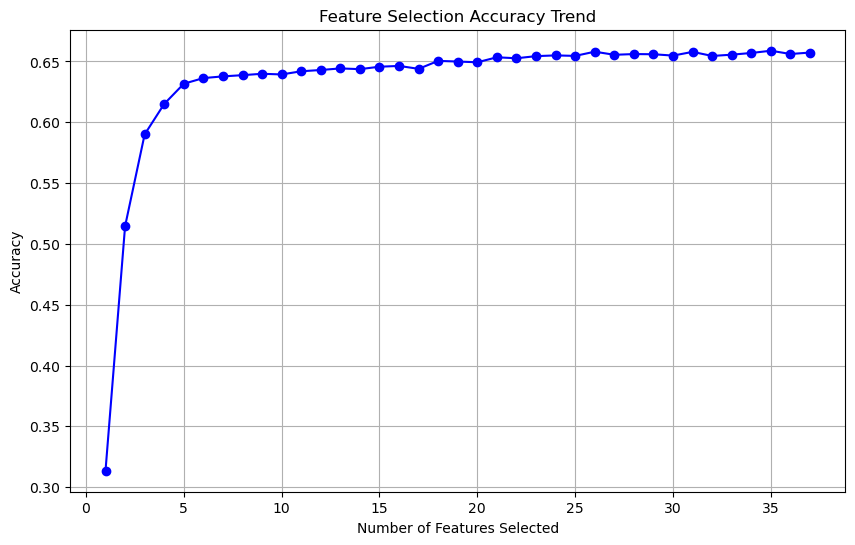

Best Accuracy: 0.6589
Best Features: ['release_year', 'runtime', 'budget', 'revenue', 'adult', 'original_language', 'popularity', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'product_of_Canada', 'product_of_France', 'product_of_Germany', 'product_of_Italy', 'product_of_Spain', 'product_of_UK', 'product_of_USA', 'product_of_other_countries', 'vote_count']
Excluded Features: ['product_of_India', 'product_of_Japan']


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

X_train = train[features_without_text]
y_train = train['rate_category']
X_evaluate = evaluate[features_without_text]
y_evaluate = evaluate['rate_category']

best_accuracy = 0
best_features = []
accuracies = []

for n_features in range(1, len(features_without_text) + 1):
    tree = DecisionTreeClassifier()
    rfe = RFE(estimator=tree, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    X_train_rfe = rfe.transform(X_train)
    X_evaluate_rfe = rfe.transform(X_evaluate)

    tree.fit(X_train_rfe, y_train)
    y_pred = tree.predict(X_evaluate_rfe)
    accuracy = accuracy_score(y_evaluate, y_pred)
    accuracies.append(accuracy) 

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = [features_without_text[i] for i in range(len(features_without_text)) if selected_features[i]]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features_without_text) + 1), accuracies, marker='o', linestyle='-', color='b')
plt.title('Feature Selection Accuracy Trend')
plt.xlabel('Number of Features Selected')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(f'Best Accuracy: {best_accuracy:.4f}')
print('Best Features:', best_features)

excluded_features = [f for f in features_without_text if f not in best_features]
print('Excluded Features:', excluded_features)


In [4]:
X_train_overview = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/train_overview_bow.npz')
X_evaluate_overview = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/eval_overview_bow.npz')
X_train_production_companies = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/train_production_companies_bow.npz')
X_evaluate_production_companies = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/eval_production_companies_bow.npz')
X_train_tagline = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/train_tagline_bow.npz')
X_evaluate_tagline = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/eval_tagline_bow.npz')
X_train_title = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/train_title_bow.npz')
X_evaluate_title = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/eval_title_bow.npz')

In [8]:
X_train_best = train[best_features]
X_evaluate_best = evaluate[best_features]

text_train_list = [X_train_overview, X_train_production_companies, X_train_tagline, X_train_title]
text_evaluate_list = [X_evaluate_overview, X_evaluate_production_companies, X_evaluate_tagline, X_evaluate_title]

dt = DecisionTreeClassifier()
# add on 1 text feature
X_train_1 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray()), axis=1)
X_evaluate_1 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray()), axis=1)
dt.fit(X_train_1, y_train)
y_pred = dt.predict(X_evaluate_1)
accuracy = accuracy_score(y_evaluate, y_pred)
print("1:", accuracy)
X_train_2 = np.concatenate((X_train_best.to_numpy(), text_train_list[1].toarray()), axis=1)
X_evaluate_2 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[1].toarray()), axis=1)
dt.fit(X_train_2, y_train)
y_pred = dt.predict(X_evaluate_2)
accuracy = accuracy_score(y_evaluate, y_pred)
print("2:", accuracy)
X_train_3 = np.concatenate((X_train_best.to_numpy(), text_train_list[2].toarray()), axis=1)
X_evaluate_3 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[2].toarray()), axis=1)
dt.fit(X_train_3, y_train)
y_pred = dt.predict(X_evaluate_3)
accuracy = accuracy_score(y_evaluate, y_pred)
print("3:", accuracy)
X_train_4 = np.concatenate((X_train_best.to_numpy(), text_train_list[3].toarray()), axis=1)
X_evaluate_4 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_4, y_train)
y_pred = dt.predict(X_evaluate_4)
accuracy = accuracy_score(y_evaluate, y_pred)
print("4:", accuracy)

# add on 2 text features
X_train_12 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[1].toarray()), axis=1)
X_evaluate_12 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[1].toarray()), axis=1)
dt.fit(X_train_12, y_train)
y_pred = dt.predict(X_evaluate_12)
accuracy = accuracy_score(y_evaluate, y_pred)
print("12:", accuracy)
X_train_13 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[2].toarray()), axis=1)
X_evaluate_13 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[2].toarray()), axis=1)
dt.fit(X_train_13, y_train)
y_pred = dt.predict(X_evaluate_13)
accuracy = accuracy_score(y_evaluate, y_pred)
print("13:", accuracy)
X_train_14 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_14 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_14, y_train)
y_pred = dt.predict(X_evaluate_14)
accuracy = accuracy_score(y_evaluate, y_pred)
print("14:", accuracy)
X_train_23 = np.concatenate((X_train_best.to_numpy(), text_train_list[1].toarray(), text_train_list[2].toarray()), axis=1)
X_evaluate_23 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[1].toarray(), text_evaluate_list[2].toarray()), axis=1)
dt.fit(X_train_23, y_train)
y_pred = dt.predict(X_evaluate_23)
accuracy = accuracy_score(y_evaluate, y_pred)
print("23:", accuracy)
X_train_24 = np.concatenate((X_train_best.to_numpy(), text_train_list[1].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_24 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[1].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_24, y_train)
y_pred = dt.predict(X_evaluate_24)
accuracy = accuracy_score(y_evaluate, y_pred)
print("24:", accuracy)
X_train_34 = np.concatenate((X_train_best.to_numpy(), text_train_list[2].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_34 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[2].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_34, y_train)
y_pred = dt.predict(X_evaluate_34)
accuracy = accuracy_score(y_evaluate, y_pred)
print("34:", accuracy)

# add on 3 text features
X_train_123 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[1].toarray(), text_train_list[2].toarray()), axis=1)
X_evaluate_123 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[1].toarray(), text_evaluate_list[2].toarray()), axis=1)
dt.fit(X_train_123, y_train)
y_pred = dt.predict(X_evaluate_123)
accuracy = accuracy_score(y_evaluate, y_pred)
print("123:", accuracy)
X_train_124 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[1].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_124 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[1].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_124, y_train)
y_pred = dt.predict(X_evaluate_124)
accuracy = accuracy_score(y_evaluate, y_pred)
print("124:", accuracy)
X_train_134 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[2].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_134 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[2].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_134, y_train)
y_pred = dt.predict(X_evaluate_134)
accuracy = accuracy_score(y_evaluate, y_pred)
print("134:", accuracy)
X_train_234 = np.concatenate((X_train_best.to_numpy(), text_train_list[1].toarray(), text_train_list[2].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_234 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[1].toarray(), text_evaluate_list[2].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_234, y_train)
y_pred = dt.predict(X_evaluate_234)
accuracy = accuracy_score(y_evaluate, y_pred)
print("234:", accuracy)

# add on 4 text features
X_train_1234 = np.concatenate((X_train_best.to_numpy(), text_train_list[0].toarray(), text_train_list[1].toarray(), text_train_list[2].toarray(), text_train_list[3].toarray()), axis=1)
X_evaluate_1234 = np.concatenate((X_evaluate_best.to_numpy(), text_evaluate_list[0].toarray(), text_evaluate_list[1].toarray(), text_evaluate_list[2].toarray(), text_evaluate_list[3].toarray()), axis=1)
dt.fit(X_train_1234, y_train)
y_pred = dt.predict(X_evaluate_1234)
accuracy = accuracy_score(y_evaluate, y_pred)
print("1234:", accuracy)

1: 0.66295
2: 0.6667
3: 0.65985
4: 0.66695
12: 0.6668
13: 0.66335
14: 0.66465
23: 0.6678
24: 0.67
34: 0.66735
123: 0.66515
124: 0.6675
134: 0.6629
234: 0.6697
1234: 0.6639


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X_train = X_train_24
# 假设X_train是训练数据，y_train是目标变量
forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)

# 使用SelectFromModel选择特征
selector = SelectFromModel(forest, prefit=True, threshold='median')  # 可调整阈值
X_train_reduced = selector.transform(X_train)

print("Original feature count:", X_train.shape[1])
print("Reduced feature count:", X_train_reduced.shape[1])


Original feature count: 2035
Reduced feature count: 1018


In [7]:
# predict test set
from sklearn.ensemble import RandomForestClassifier

X_test_overview = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/test_overview_bow.npz')
X_test_production_companies = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/test_production_companies_bow.npz')
X_test_tagline = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/test_tagline_bow.npz')
X_test_title = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/test_title_bow.npz')
text_test_list = [X_test_overview, X_test_production_companies, X_test_tagline, X_test_title]

X_test_best = test[best_features]

X_test_24 = np.concatenate((X_test_best.to_numpy(), text_test_list[1].toarray(), text_test_list[3].toarray()), axis=1)

rf = RandomForestClassifier()
rf.fit(X_train_24, y_train_category)
y_pred_test = rf.predict(X_test_24)

assert test.shape[0] == len(y_pred_test)

test["rate_category"] = y_pred_test

test_out = test[["id", "rate_category"]]
test_out.to_csv('test_predictions.csv', index=False)